<a href="https://colab.research.google.com/github/mekhiya/pytorch-playground/blob/main/02_neural_network_classification_with_pytorch_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [365]:
## Make classification
# sklearn - focused on machine learning
# pytorch - focused around machine learning

In [366]:
import sklearn
from sklearn.datasets import make_circles

In [367]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [368]:
print(f"First 5 of X : \n {X[:5]}")
print(f"First 5 of y : \n {y[:5]}")

First 5 of X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 of y : 
 [1 1 1 1 0]


In [369]:
# Make Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


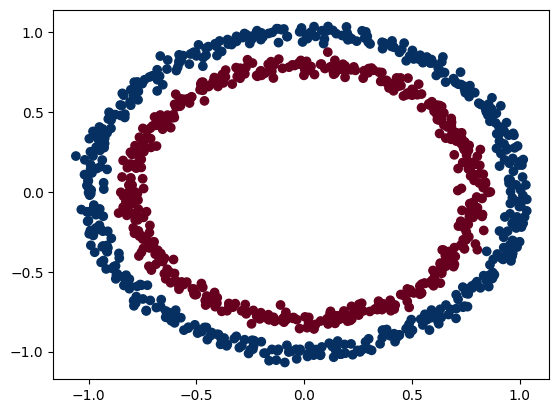

In [370]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdBu_r);

In [371]:
x_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {x_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {x_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [372]:
# Turn toy data into tensors and create train & test splits

import torch
torch.__version__

'2.1.0+cu118'

In [373]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [374]:
# Split data into training & test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test)

(800, 200)

In [375]:
# 2. Building a model

# Let's build model to classify Red & blue dots
# 1. device agnostic code
# 2. COnstruct a model (by sunclassing `nn.module`)
# 3. Define a loss function and optimizer
# 4. Create a training and test loop

In [376]:
# import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [377]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear (in_features=5,
                              out_features=1)

  # Define a forward method that outlines forward path
  def forward(self, X):
    return self.layer_2(self.layer_1(X)) # X => layer_1 -> layer_2

In [378]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [379]:
next(model_0.parameters()).device

device(type='cpu')

In [380]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [381]:
# Make predicitons
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predcitions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 predictions:\n {untrained_preds[:10]}")
print(f"First 10 labels:\n {y_test[:10]}")

Length of predcitions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions:
 tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]])
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [382]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # uses sigmoid activation function

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [383]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [384]:
# 1 . Forward pass
# 2. calcualte loss
# 3. Optimizer zero grad
# 4. Loss backward (backpropogation)
# 5. Optimizer gradient

Going from raw logits -> prediction probabilities ->  prediciton labels


In [385]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])

In [386]:
# Use the sigmoid activation function on our model logits to turn them into prediction
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]])

In [387]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [388]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [389]:
# Build a training & testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  # forward
  # loss calucaltion
  # zero optimiser grade
  # loss backward
  # step
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Loos / accuracy (optional)
  loss = loss_fn(torch.sigmoid(y_logits),
                 y_train)
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. optimizer.zero_grad()
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. optimizer.step()
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc: .2f}% | Test loss: {test_loss: .5f}, Test acc: {test_acc: .2f}%")







Epoch: 0 | Loss:  0.69569, Acc:  50.00% | Test loss:  0.69721, Test acc:  50.00%
Epoch: 10 | Loss:  0.69403, Acc:  50.00% | Test loss:  0.69615, Test acc:  50.00%
Epoch: 20 | Loss:  0.69343, Acc:  46.00% | Test loss:  0.69585, Test acc:  48.50%
Epoch: 30 | Loss:  0.69321, Acc:  49.00% | Test loss:  0.69577, Test acc:  47.50%
Epoch: 40 | Loss:  0.69312, Acc:  49.50% | Test loss:  0.69573, Test acc:  46.50%
Epoch: 50 | Loss:  0.69308, Acc:  50.38% | Test loss:  0.69569, Test acc:  46.50%
Epoch: 60 | Loss:  0.69306, Acc:  50.50% | Test loss:  0.69564, Test acc:  46.50%
Epoch: 70 | Loss:  0.69305, Acc:  50.50% | Test loss:  0.69559, Test acc:  46.50%
Epoch: 80 | Loss:  0.69304, Acc:  50.75% | Test loss:  0.69553, Test acc:  46.50%
Epoch: 90 | Loss:  0.69303, Acc:  50.38% | Test loss:  0.69547, Test acc:  46.50%


In [390]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already not downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


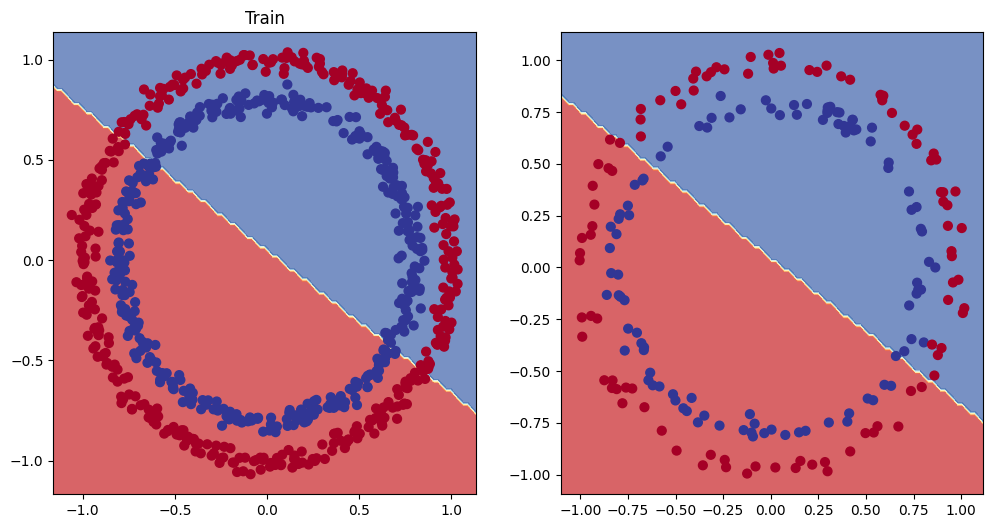

In [391]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_0, X_test, y_test)

In [392]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
  def forward(self, x):
  # z = self.layer_1(x)
  # z = self.layer_2(z)
  # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [393]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [394]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [395]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Optimizer Step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


    # Print out
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")




Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 100 | Loss: 0.69305, Acc: 50.38 | Test loss: 0.69379, Test acc: 48.00
Epoch: 200 | Loss: 0.69299, Acc: 51.12 | Test loss: 0.69437, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Acc: 51.62 | Test loss: 0.69458, Test acc: 45.00
Epoch: 400 | Loss: 0.69298, Acc: 51.12 | Test loss: 0.69465, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69467, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00


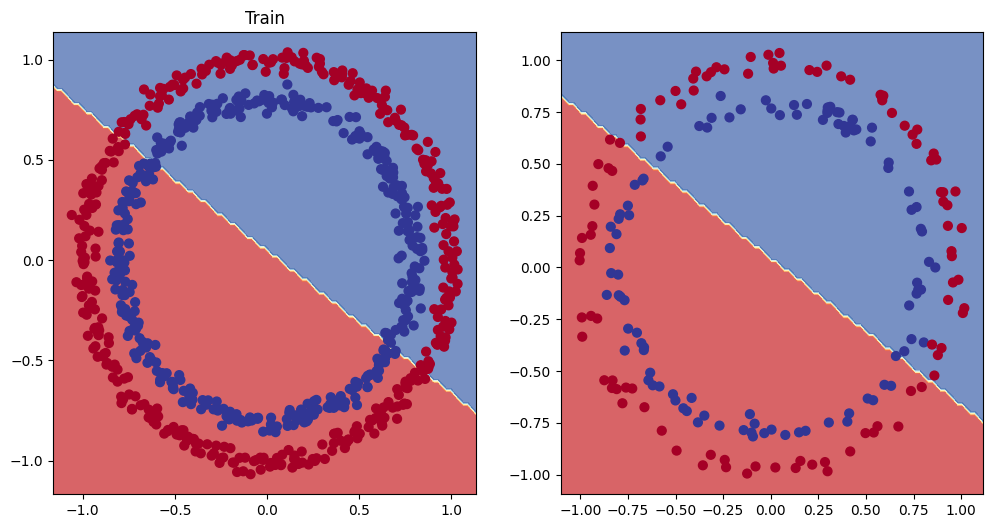

In [396]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_0, X_test, y_test)

In [397]:
# create soem data (same as 01 workflow)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear rgression formula (without epsilon)

print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [398]:
# create train split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

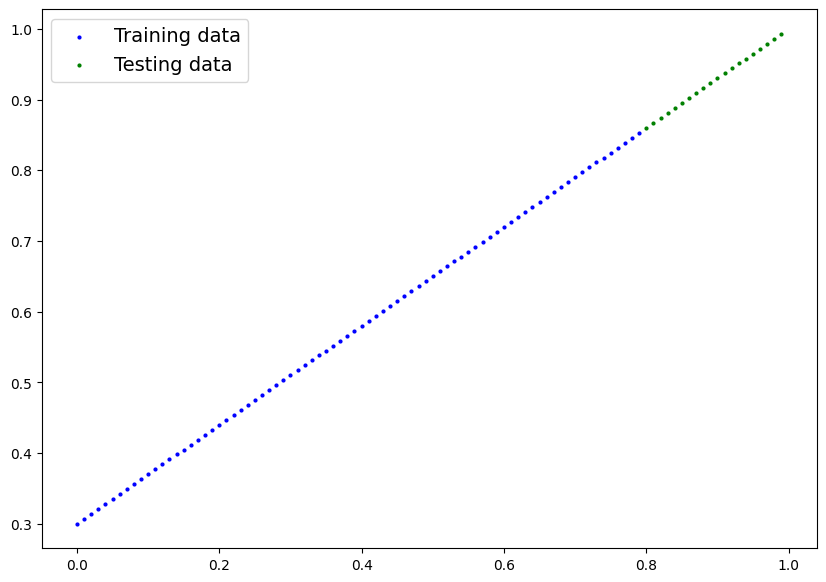

In [399]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);


In [400]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [401]:
# Same architecture as model_1 (but using nn.sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2



Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [402]:
# Loss & optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.01)

In [403]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred=model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {test_loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.91103 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.00081 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.00209 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.00305 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.00341 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.00387 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.00379 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.00381 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.00329 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.00360 | Test Loss: 0.00360


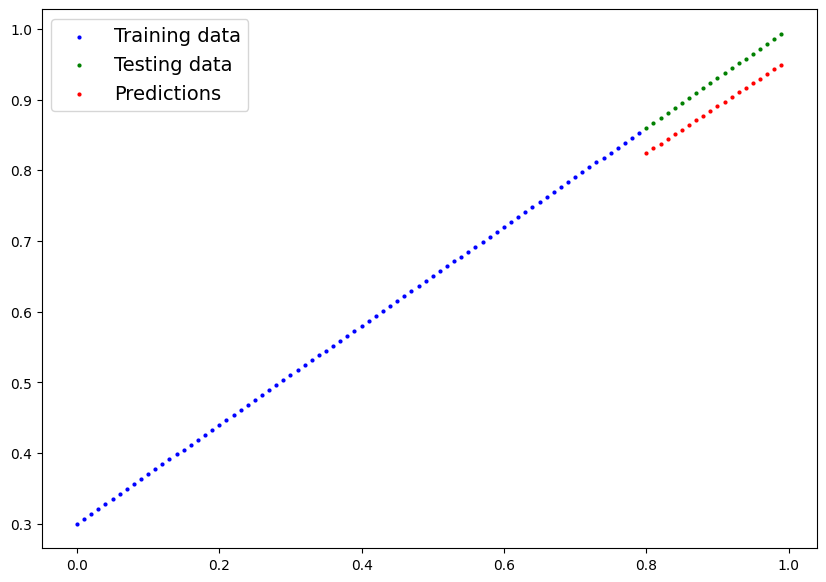

In [404]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

  # Plot data and predictions
  plot_predictions(train_data=X_train_regression.cpu(),
                   train_labels=y_train_regression.cpu(),
                   test_data=X_test_regression.cpu(),
                   test_labels=y_test_regression.cpu(),
                   predictions=y_preds.cpu());

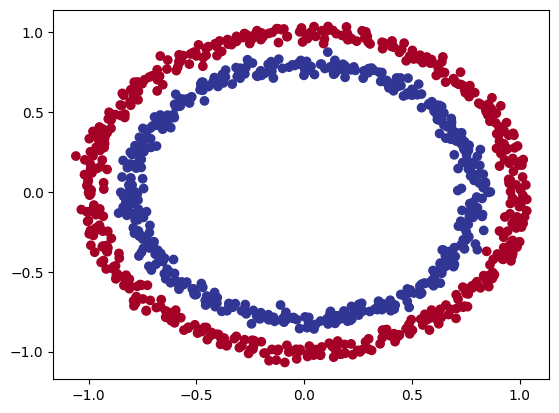

In [405]:
# The missing piece: non-linearity

# What pattern could you draw if you were given an infinite amoutn of a straight & non straight lines?
# linear & non-linear functions

## NON-LINEARITY

# Recreating non-linear data ( red & blue circles)

# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)


In [406]:
# Convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [407]:
# Building a model with non-linearity

# Build a model with non linear activation

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [408]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [409]:
# spam or not spam
# credit crd fraud or no fraud
# insurance claims = at fault or not at fault

# Training model with non linearity
# Random seeds

torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  #Training
  model_3.train()

  #1. Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3. Optimizer Zero Grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenning
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [410]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

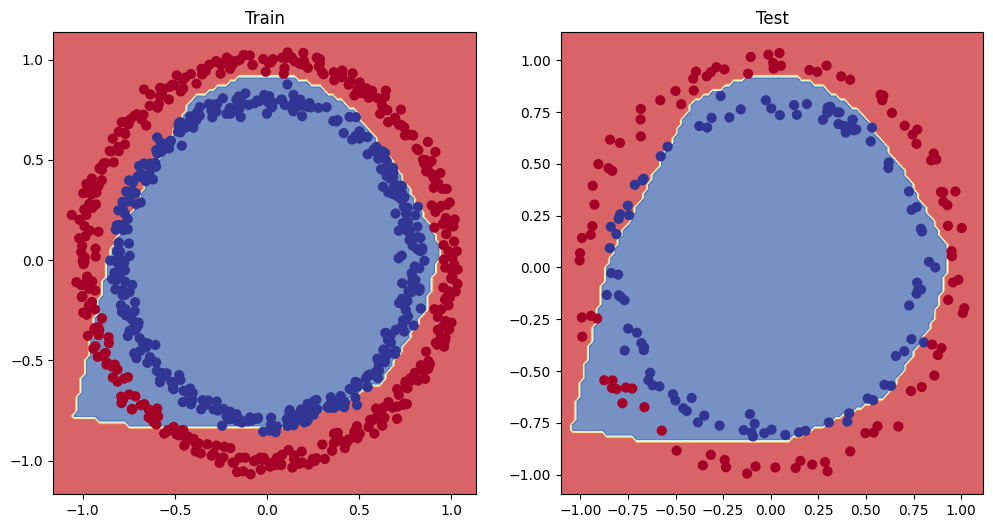

In [411]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [412]:
# Create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)


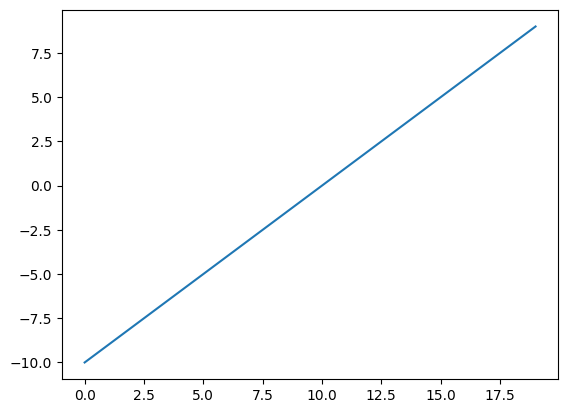

In [413]:
# Visuaise the tensor
plt.plot(A);

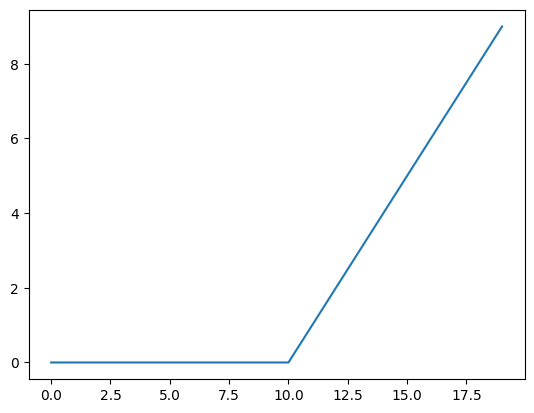

In [414]:
plt.plot(torch.relu(A));

In [415]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

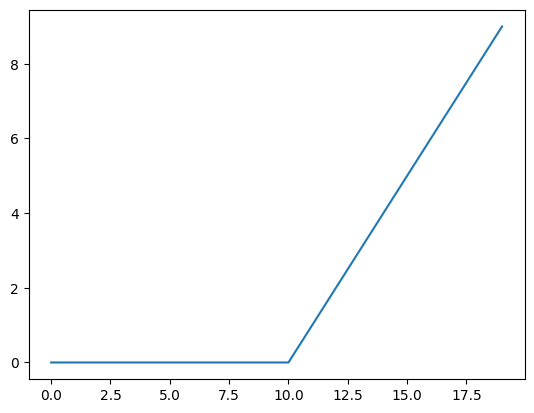

In [416]:
# Plot ReLU activation function
plt.plot(relu(A))

In [417]:
# Now let's implement sigmoid
def sigmoid(x):
  return 1/ (1 + torch.exp(-x))

In [418]:
sigmoid(A), torch.sigmoid(A)

(tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
         1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
         8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
         9.9966e-01, 9.9988e-01]),
 tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
         1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
         8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
         9.9966e-01, 9.9988e-01]))

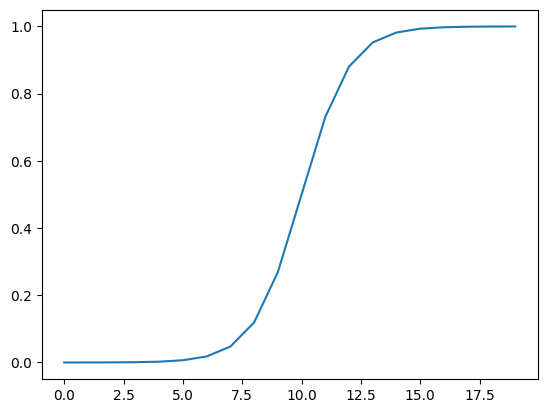

In [419]:
plt.plot(torch.sigmoid(A));

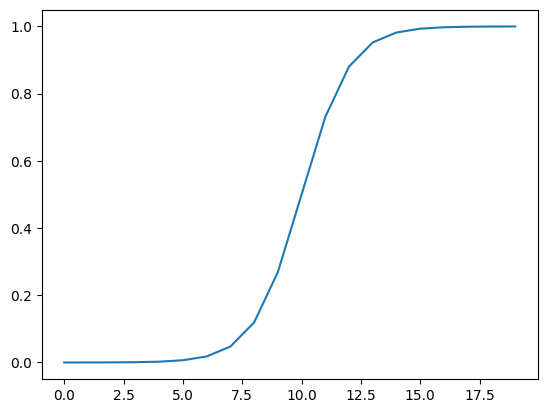

In [420]:
plt.plot(sigmoid(A));

In [421]:
# 8. Putting it all together with a multi-class classfication problem
# Binary classification = one thing or another - spam or no spam - cat or dog

# Multiclass calssfication - more than one thing or another - cat vs dog vs horse

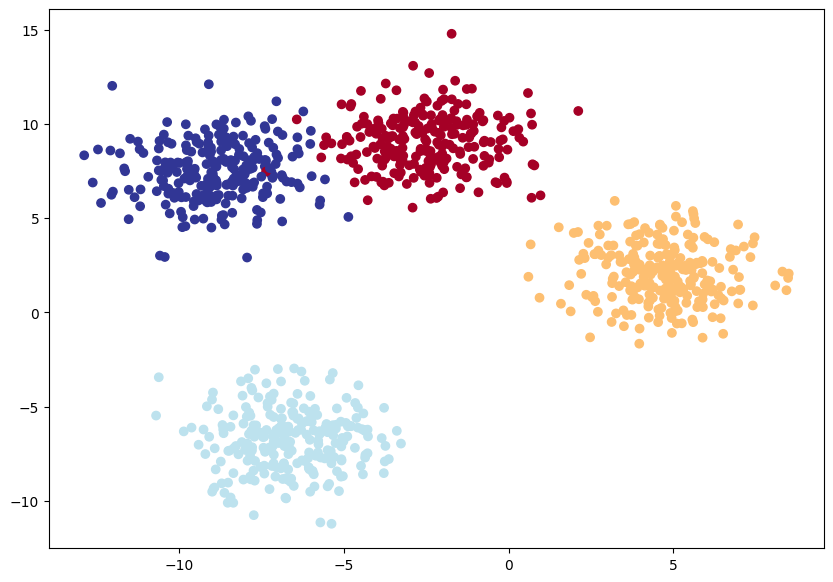

In [422]:
# 8.1 Creating a toy multi-class dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-clas data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2 TUrn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (VIsualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


In [423]:
# Building a multi-class classification model in PyTorch

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [424]:
class BlobModel(nn.Module):
  def __init__(self,input_features, output_features, hidden_units=8):
    super().__init__()
    """ Initializes multi-class classificaiton model
        Args:
          input features (int): Number of input features to the model
          output_features (int):  Number of output features
          hidden_units (int): Number of hidden units between layers, default 8

        Returns:

        Example:

    """
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)


In [425]:
# X_blob_train.shape, torch.unique(y_blob_train)

In [426]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [427]:
# Create a loss function and optimizer for a multi-class calssification

loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optmizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

In [428]:
# In order to evaluate and train and test our model, we need to convert our model's outputs
# (logits) to prediction probabilities and then to prediction labels.
# logits -> Pred probs -> Pred labels

In [429]:
# Getting predicitons probabilities for a multi-class PyTorch model
model_4(X_blob_test.to(device))
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [430]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [431]:
# Convert our model's Prediction probabilities to Prediction Label

y_preds = torch.argmax(y_pred_probs, dim=1)
# y_preds, y_blob_test

In [432]:
### Creating a training and testing loop for a multi class PyTorch model

In [433]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  print(f"y_logits : {y_logits.shape} | , y_blob_train:  {y_blob_train.shape}")
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    # Print our what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
Epoch: 0 | Loss: 1.15883, Accuracy: 40.38% | Test Loss: 1.15549, Test Accuracy: 35.50%
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800])
Epoch: 10 | Loss: 1.15883, Accuracy: 40.38% | Test Loss: 1.15549, Test Accuracy: 35.50%
y_logits : torch.Size([800, 4]) | , y_blob_train:  torch.Size([800

In [434]:
# plot_decision_boundary(X=,model=,y=,)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# y_logits[:10]

# logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)

# Pred probs -> Pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)


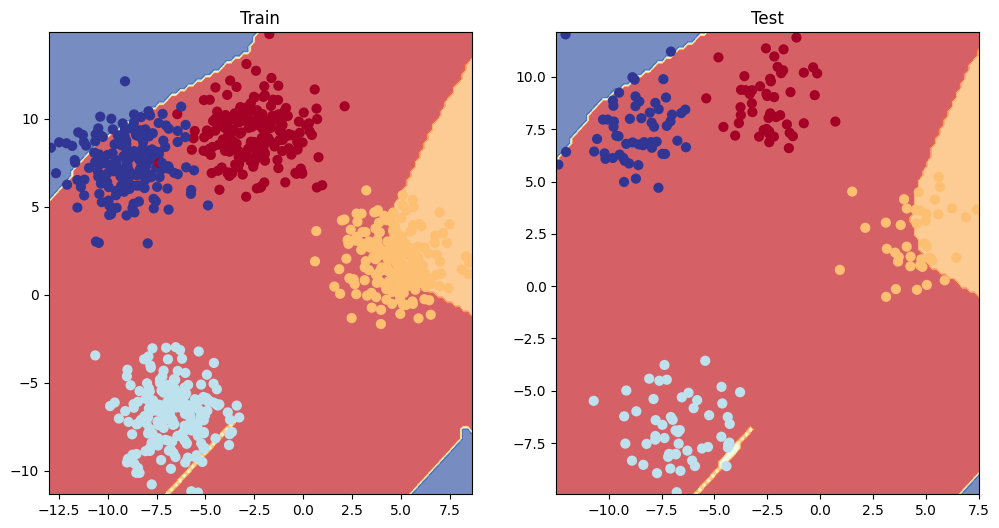

In [435]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)